In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from bs4 import BeautifulSoup
import re,string,unicodedata
from tensorflow.keras.preprocessing import text, sequence
from sklearn.metrics import classification_report,confusion_matrix,accuracy_score
from sklearn.model_selection import train_test_split
from string import punctuation
from nltk.corpus import wordnet
import tensorflow.keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Embedding,LSTM,Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from sklearn.naive_bayes import MultinomialNB
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report
from sklearn.datasets import load_digits
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit

# load data

In [2]:
train = pd.read_csv("liar/train.tsv")
val = pd.read_csv("liar/valid.tsv")
train['test']=0
val['test']=0

train.loc[train['category'] == 'TRUE', 'test'] = 1
train.loc[train['category'] == 'mostly-true', 'test'] = 1

val.loc[val['category'] == 'TRUE', 'test'] = 1
val.loc[val['category'] == 'mostly-true', 'test'] = 1

df=train


# data Processing

In [3]:
stopW = set(stopwords.words('english'))
punctuation = list(string.punctuation)
stopW.update(punctuation)

def strip(text):
    soup = BeautifulSoup(text, "html.parser")
    return soup.get_text()
def remove_noise(text):
    return re.sub(r'http\S+\[[^]]*\]', '', text)
def remove_stopwords(text):
    final_text = []
    for i in text.split():
        if i.strip().lower() not in stopW:
            final_text.append(i.strip())
    return " ".join(final_text)
#Remove noise
def denoise_text(text):
    text = strip(text)
    text = remove_noise(text)
    text = remove_stopwords(text)
    return text

df['text']=df['text'].apply(denoise_text)
val['text']=val['text'].apply(denoise_text)


In [4]:
X_train = df.text
Y_train = df.test
X_test = val.text
Y_test = val.test

In [5]:
stopwords = stopW

# Vocab list

In [6]:
# Building a vocabulary of words from the given documents
vocab = {}
for X_train_s in X_train:
    word_list = []
    for word in X_train_s.split():
        word_new  = word.strip(string.punctuation).lower()
        if (len(word_new)>2):  
            if word_new in vocab:
                vocab[word_new]+=1
            else:
                vocab[word_new]=1            

In [7]:
num_words = [0 for i in range(max(vocab.values())+1)] 
freq = [i for i in range(max(vocab.values())+1)] 
for key in vocab:
    num_words[vocab[key]]+=1
cutoff_freq = 80
num_words_above_cutoff = len(vocab)-sum(num_words[0:cutoff_freq])

features = []
for key in vocab:
    if vocab[key] >=cutoff_freq:
        features.append(key)

In [8]:
X_train_dataset = np.zeros((len(X_train),len(features)))
# This can take some time to complete
i=0
for X_train_s in X_train:
    # print(i) # Uncomment to see progress
    word_list = [ word.strip(string.punctuation).lower() for word in X_train_s.split()]
    for word in word_list:
        if word in features:
            X_train_dataset[i][features.index(word)] += 1
    i=i+1

In [9]:
X_test_dataset = np.zeros((len(X_test),len(features)))
i=0
for X_test_s in X_test:
    word_list = [ word.strip(string.punctuation).lower() for word in X_test_s.split()]
    for word in word_list:
        if word in features:
            X_test_dataset[i][features.index(word)] += 1
    i=i+1

# sklearn's Multinomial Naive Bayes

In [10]:
# Using sklearn's Multinomial Naive Bayes
clf = MultinomialNB()
clf.fit(X_train_dataset,Y_train)
Y_test_pred = clf.predict(X_test_dataset)
sklearn_score_train = clf.score(X_train_dataset,Y_train)
print("Sklearn's score on training data :",sklearn_score_train)
sklearn_score_test = clf.score(X_test_dataset,Y_test)
print("Sklearn's score on testing data :",sklearn_score_test)
print("Classification report for testing data :-")
print(classification_report(Y_test, Y_test_pred))

Sklearn's score on training data : 0.65966796875
Sklearn's score on testing data : 0.6728971962616822
Classification report for testing data :-
              precision    recall  f1-score   support

           0       0.72      0.85      0.78       864
           1       0.50      0.31      0.38       420

    accuracy                           0.67      1284
   macro avg       0.61      0.58      0.58      1284
weighted avg       0.65      0.67      0.65      1284



In [11]:
from sklearn import metrics
metrics.accuracy_score(Y_test, Y_test_pred)

0.6728971962616822

In [12]:
y_train_pre = clf.predict(X_train_dataset)
accuracy_score(Y_train, y_train_pre)

0.65966796875

In [13]:
cm = metrics.confusion_matrix(Y_test, Y_test_pred)
cm = pd.DataFrame(cm , index = ['Fake','Original'] , columns = ['Fake','Original'])

Text(69.0, 0.5, 'Actual')

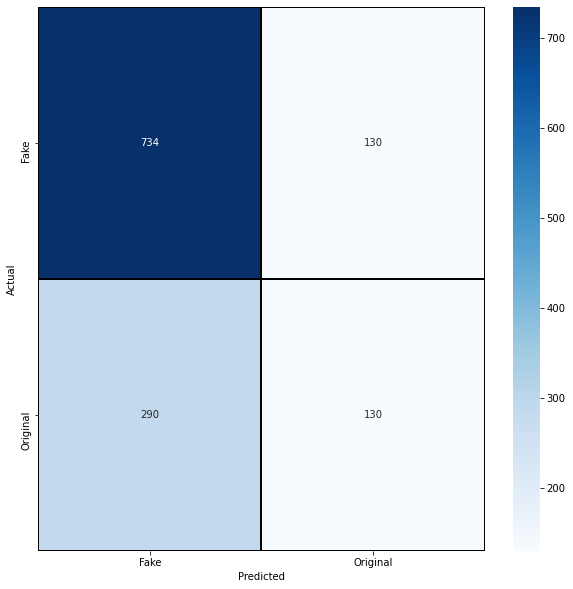

In [14]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='' , xticklabels = ['Fake','Original'] , yticklabels = ['Fake','Original'])
plt.xlabel("Predicted")
plt.ylabel("Actual")

# sklearn's Gaussian Naive Bayes


In [15]:
# Using sklearn's Gaussian Naive Bayes
clf =  GaussianNB()
clf.fit(X_train_dataset,Y_train)
Y_test_pred = clf.predict(X_test_dataset)
sklearn_score_train = clf.score(X_train_dataset,Y_train)
print("Sklearn's score on training data :",sklearn_score_train)
sklearn_score_test = clf.score(X_test_dataset,Y_test)
print("Sklearn's score on testing data :",sklearn_score_test)
print("Classification report for testing data :-")
print(classification_report(Y_test, Y_test_pred))

Sklearn's score on training data : 0.614453125
Sklearn's score on testing data : 0.6222741433021807
Classification report for testing data :-
              precision    recall  f1-score   support

           0       0.75      0.66      0.70       864
           1       0.44      0.55      0.49       420

    accuracy                           0.62      1284
   macro avg       0.59      0.60      0.59      1284
weighted avg       0.65      0.62      0.63      1284



In [16]:
def plot_learning_curve(
    estimator,
    title,
    X,
    y,
    axes=None,
    ylim=None,
    cv=None,
    n_jobs=None,
    train_sizes=np.linspace(0.1, 1.0, 5),
):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = learning_curve(
        estimator,
        X,
        y,
        cv=cv,
        n_jobs=n_jobs,
        train_sizes=train_sizes,
        return_times=True,
    )
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(
        train_sizes,
        train_scores_mean - train_scores_std,
        train_scores_mean + train_scores_std,
        alpha=0.1,
        color="r",
    )
    axes[0].fill_between(
        train_sizes,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
        color="g",
    )
    axes[0].plot(
        train_sizes, train_scores_mean, "o-", color="r", label="Training score"
    )

    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, "o-")
    axes[1].fill_between(
        train_sizes,
        fit_times_mean - fit_times_std,
        fit_times_mean + fit_times_std,
        alpha=0.1,
    )
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, "o-")
    axes[2].fill_between(
        fit_times_mean,
        test_scores_mean - test_scores_std,
        test_scores_mean + test_scores_std,
        alpha=0.1,
    )
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt

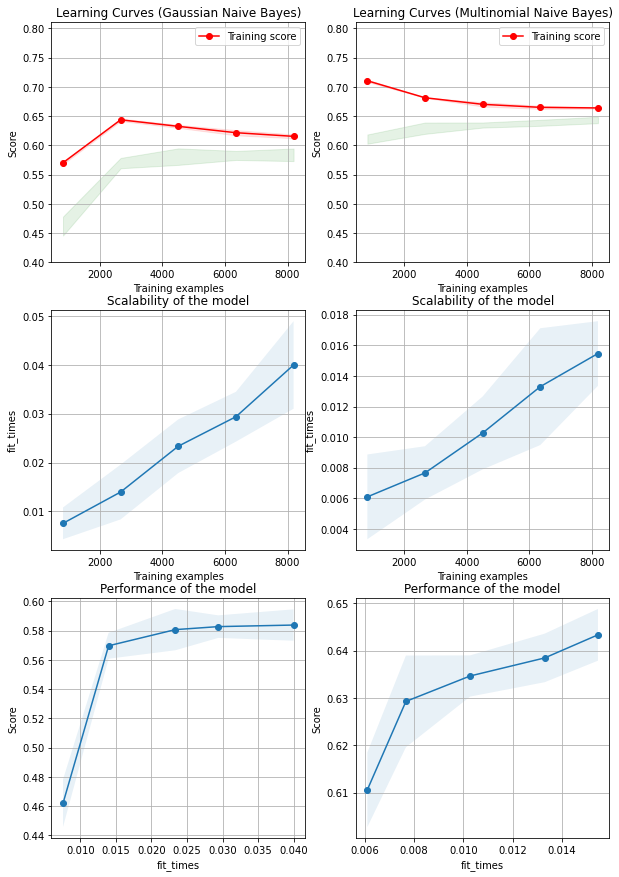

In [18]:
fig, axes = plt.subplots(3, 2, figsize=(10, 15))


title = "Learning Curves (Gaussian Naive Bayes)"
# Cross validation with 100 iterations to get smoother mean test and train
# score curves, each time with 20% data randomly selected as a validation set.

estimator = GaussianNB()
plot_learning_curve(
    estimator, title, X_train_dataset,Y_train, axes=axes[:, 0], ylim=(0.4, 0.81), n_jobs=4
)

title = "Learning Curves (Multinomial Naive Bayes)"
# SVC is more expensive so we do a lower number of CV iterations:
estimator = MultinomialNB()
plot_learning_curve(
    estimator, title, X_train_dataset,Y_train, axes=axes[:, 1], ylim=(0.4, 0.81), n_jobs=4
)
plt.show()
